Make the notebook wider (if you think this makes the notebook look prettier)

In [ ]:
# %load lazy_pipeline.py
import time
from typing import Iterator, List, Collection, Callable

import pandas as pd
from tqdm import tqdm

# A very general type hint for a prediction function.
# A prediction function takes a triplet of (test object description, train descriptions, train labels)
# and outputs a bool prediction
PREDICTION_FUNCTION_HINT = Callable[
    [Collection, Collection[Collection], Collection[bool]], bool
]


def load_data(df_name: str) -> pd.DataFrame:
    """Generalized function to load datasets in the form of pandas.DataFrame"""
    if df_name == 'tic_tac_toe':
        return load_tic_tac_toe()

    raise ValueError(f'Unknown dataset name: {df_name}')


def load_tic_tac_toe() -> pd.DataFrame:
    """Load tic-tac-toe dataset from UCI repository"""
    column_names = [
        'top-left-square', 'top-middle-square', 'top-right-square',
        'middle-left-square', 'middle-middle-square', 'middle-right-square',
        'bottom-left-square', 'bottom-middle-square', 'bottom-right-square',
        'Class'
    ]
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data'
    df = pd.read_csv(url, names=column_names)
    df['Class'] = [x == 'positive' for x in df['Class']]
    return df


def binarize_X(X: pd.DataFrame) -> 'pd.DataFrame[bool]':
    """Scale values from X into pandas.DataFrame of binary values"""
    dummies = [pd.get_dummies(X[f], prefix=f, prefix_sep=': ') for f in X.columns]
    X_bin = pd.concat(dummies, axis=1).astype(bool)
    return X_bin


def predict_with_generators(
        x: set, X_train: List[set], Y_train: List[bool],
        min_cardinality: int = 1
) -> bool:
    """Lazy prediction for ``x`` based on training data ``X_train`` and ``Y_train``

    Parameters
    ----------
    x : set
        Description to make prediction for
    X_train: List[set]
        List of training examples
    Y_train: List[bool]
        List of labels of training examples
    min_cardinality: int
        Minimal size of an intersection required to count for counterexamples

    Returns
    -------
    prediction: bool
        Class prediction for ``x`` (either True or False)
    """
    X_pos = [x_train for x_train, y in zip(X_train, Y_train) if y]
    X_neg = [x_train for x_train, y in zip(X_train, Y_train) if not y]

    n_counters_pos = 0  # number of counter examples for positive intersections
    for x_pos in X_pos:
        intersection_pos = x & x_pos
        if len(intersection_pos) < min_cardinality:  # the intersection is too small
            continue

        for x_neg in X_neg:  # count all negative examples that contain intersection_pos
            if (intersection_pos & x_neg) == intersection_pos:
                n_counters_pos += 1

    n_counters_neg = 0  # number of counter examples for negative intersections
    for x_neg in X_neg:
        intersection_neg = x & x_neg
        if len(intersection_neg) < min_cardinality:
            continue

        for x_pos in X_pos:  # count all positive examples that contain intersection_neg
            if (intersection_neg & x_pos) == intersection_neg:
                n_counters_neg += 1

    perc_counters_pos = n_counters_pos / len(X_pos)
    perc_counters_neg = n_counters_neg / len(X_neg)

    prediction = perc_counters_pos < perc_counters_neg
    return prediction


def predict_array(
        X: List[set], Y: List[bool],
        n_train: int, update_train: bool = True, use_tqdm: bool = False,
        predict_func: PREDICTION_FUNCTION_HINT = predict_with_generators
) -> Iterator[bool]:
    """Predict the labels of multiple examples from ``X``

    Parameters
    ----------
    X: List[set]
        Set of train and test examples to classify represented with subsets of attributes
    Y: List[bool]
        Set of train and test labels for each example from X
    n_train: int
        Initial number of train examples. That is, make predictions only for examples from X_train[n_train:]
    update_train: bool
        A flag whether to consider true labels of predicted examples as training data or not.
        If True, then for each X_i the training data consists of X_1, X_2, ..., X_{n_train}, ...,  X_{i-1}.
        If False, then for each X_i the training data consists of X_1, X_2, ..., X_{n_train}
    use_tqdm: bool
        A flag whether to use tqdm progress bar (in case you like progress bars)
    predict_func: <see PREDICTION_FUNCTION_HINT defined in this file>
        A function to make prediction for each specific example from ``X``.
        The default prediction function is ``predict_with_generator`` (considered as baseline for the home work).

    Returns
    -------
    prediction: Iterator
        Python generator with predictions for each x in X[n_train:]
    """
    for i, x in tqdm(
        enumerate(X[n_train:]),
        initial=n_train, total=len(X),
        desc='Predicting step by step',
        disable=not use_tqdm,
    ):
        n_trains = n_train + i if update_train else n_train
        yield predict_func(x, X[:n_trains], Y[:n_trains])


def apply_stopwatch(iterator: Iterator):
    """Measure run time of each iteration of ``iterator``

    The function can be applied e.g. for the output of ``predict_array`` function
    """
    outputs = []
    times = []

    t_start = time.time()
    for out in iterator:
        dt = time.time() - t_start
        outputs.append(out)
        times.append(dt)
        t_start = time.time()

    return outputs, times


In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

Import the library with all predefine functions

In [4]:
import lazy_pipeline as lpipe

Check library versions

In [5]:
from platform import python_version
import sklearn
print(python_version())
print(lpipe.pd.__version__)
print(sklearn.__version__)

3.8.9
1.5.1
1.1.2


Run seamlessly on 
* python = 3.9.13, 
* pandas = 1.5.1
* scikit-learn = 1.1.3

# Prepare the data

Load data

In [6]:
df = lpipe.load_data('tic_tac_toe')
print(df.shape)
df.head()

(958, 10)


,top-left-square,top-middle-square,top-right-square,middle-left-square,middle-middle-square,middle-right-square,bottom-left-square,bottom-middle-square,bottom-right-square,Class
0,x,x,x,x,o,o,x,o,o,True
1,x,x,x,x,o,o,o,x,o,True
2,x,x,x,x,o,o,o,o,x,True
3,x,x,x,x,o,o,o,b,b,True
4,x,x,x,x,o,o,b,o,b,True


Binarize data

In [7]:
y_name = 'Class'

In [ ]:
y = df[y_name]
X = lpipe.binarize_X(df.drop(y_name, axis=1))
print(X.shape)
X.head()

Shuffle the data to drop any initial ordering of rows. For example, if the dataset is constructed first from all positive examples and then all negative examples.

_NB: Skip this step if your data is sequential and rows ordering is important. For example, if your dataset contains a "date" feature._

In [7]:
X = X.sample(frac=1, random_state=42)  # Shuffle X
y = y[X.index]  # Order y to follow the order of rows from X

Represent data $X$ as list of subsets of attributes to better suit the theory.

In [8]:
X_bin = [set(X.columns[x]) for idx, x in X.iterrows()]
X_bin[0]

{'bottom-left-square: x',
 'bottom-middle-square: o',
 'bottom-right-square: x',
 'middle-left-square: b',
 'middle-middle-square: x',
 'middle-right-square: x',
 'top-left-square: o',
 'top-middle-square: o',
 'top-right-square: o'}

And, for being consisted, convert $y$ to list too.

In [9]:
y = y.values.tolist()

Assume that at the very begining, we know the labels only for the first 20% of rows.

In [10]:
n_train = int(len(X)*0.1)
n_test = len(X) - n_train
n_train, n_test

(95, 863)

Set up the test target labels $y$

In [11]:
y_test = y[n_train:]

# Make predictions

Make predictions and measure time required to obtain these predictions

In [12]:
%%time
gen = lpipe.predict_array(X_bin, y, n_train, use_tqdm=True)
y_preds, t_preds = lpipe.apply_stopwatch(gen)

Predicting step by step: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 958/958 [00:15<00:00, 55.31it/s]

CPU times: user 15.6 s, sys: 23.5 ms, total: 15.6 s
Wall time: 15.6 s


In [13]:
%%time
gen = list(lpipe.predict_array(X_bin, y, n_train, use_tqdm=True, update_train=False))
y_preds_fixedtrain, t_preds_fixedtrain = lpipe.apply_stopwatch(gen)

Predicting step by step: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 958/958 [00:00<00:00, 1656.38it/s]

CPU times: user 517 ms, sys: 8 ms, total: 525 ms
Wall time: 523 ms


Evaluate predictions

Here we decided to measure Accuracy and F1 score simply because there ones of the most popular scores. Feel free to use more elaborate scorings.

In [14]:
from sklearn.metrics import accuracy_score, f1_score

score_vals = {}
for score_f in [accuracy_score, f1_score]:
    score_name = score_f.__name__
    preds = y_preds
    score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]
    
    score_name = score_f.__name__ + '_fixedtrain'
    preds = y_preds_fixedtrain
    score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]

# Analyze results

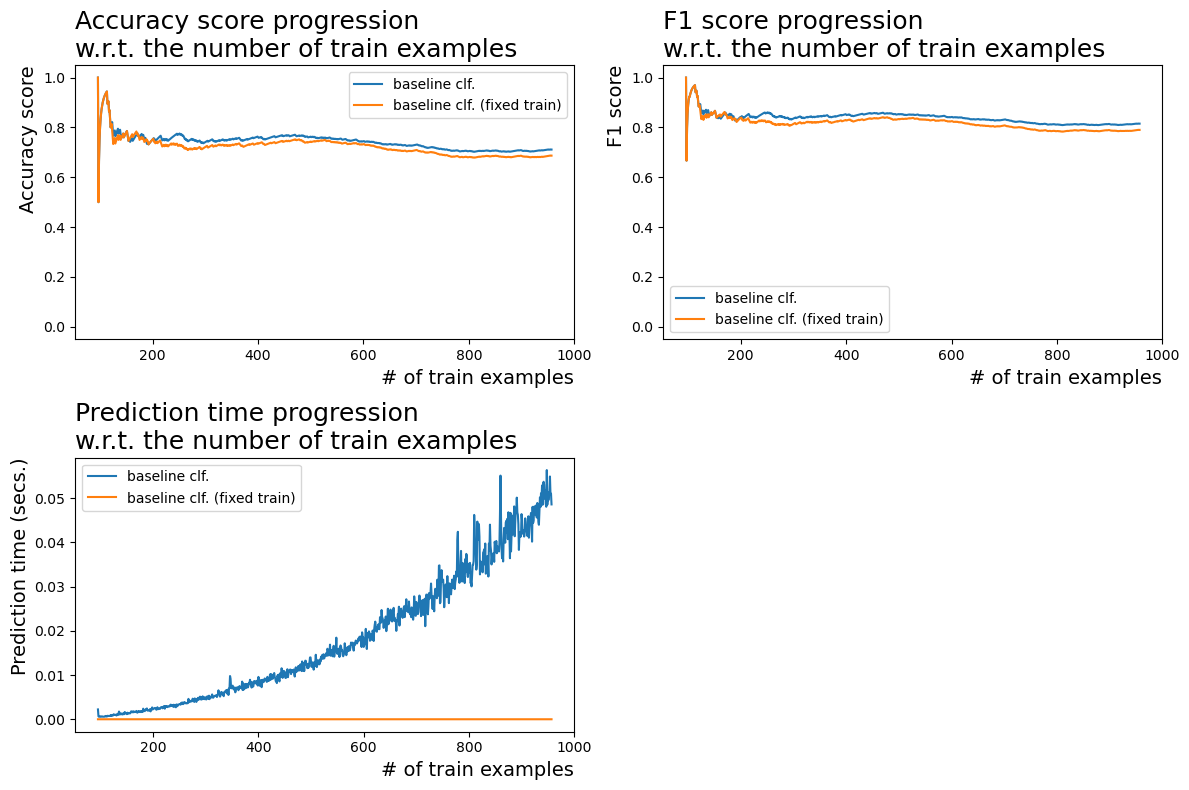

In [15]:
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = (1,1,1,1)  # Replace default "transparent" background of the figure with the "white" one


fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# First two plots are for prediction quality comparison
for ax, t in zip(axs[0],['accuracy_score', 'f1_score']):
    ax.set_ylim(0-0.05, 1+0.05)
    ax.plot(range(n_train+1, len(X)), score_vals[t], label='baseline clf.')
    ax.plot(range(n_train+1, len(X)), score_vals[t+'_fixedtrain'], label='baseline clf. (fixed train)')
    
# The third plot is for prediction speed comparison
axs[1,0].plot(range(n_train, len(X)), t_preds, label='baseline clf.')
axs[1,0].plot(range(n_train, len(X)), t_preds_fixedtrain, label='baseline clf. (fixed train)')

# Add labels and titles to the plots
for (ax, t_verb, dim) in zip(axs.flatten(), ['Accuracy score', 'F1 score', 'Prediction time'], ['','','(secs.)']):
    ax.set_title('\n'.join([f"{t_verb} progression", "w.r.t. the number of train examples"]), loc='left', size=18)
    ax.set_xlabel('# of train examples', loc='right', size=14)
    ax.set_ylabel(f"{t_verb} {dim}".strip(), loc='top', size=14)
    ax.legend()
    
# Drop the predefined fourth plot since we do not use it
axs[1,1].set_axis_off()    

# Some postprocessing of plots
plt.tight_layout()
plt.subplots_adjust()

plt.savefig('Classifier_comparison.png')
plt.show()

In conclusion:

...